In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

!python -V
# print(sklearn.__version__)

Python 3.8.8


In [2]:
o_df = pd.read_csv('Tsimiski_st.csv', sep=',') # parse_dates = ['date_time'], index_col = ['date_time']

# Converting date_time format 
o_df['date_time'] = o_df['date_time'].astype('datetime64[ns]')
o_df['year'] = o_df['date_time'].dt.year

o_df.dropna(axis=0, how='any', inplace=True)

o_df

,osm_id,date_time,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
0,13769164,2018-01-01 00:00:00,1,25,00:00,0,0,2,0,1,primary,72.0,no,2018
1,13769164,2018-01-01 00:15:00,1,22,00:15,0,15,2,0,1,primary,72.0,no,2018
2,13769164,2018-01-01 00:30:00,1,12,00:30,0,30,2,0,1,primary,72.0,no,2018
3,13769164,2018-01-01 00:45:00,1,4,00:45,0,45,2,0,1,primary,72.0,no,2018
4,13769164,2018-01-01 01:00:00,1,5,01:00,1,0,2,0,1,primary,72.0,no,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390917,176665188,2022-02-28 23:00:00,1,38,23:00,23,0,2,0,2,primary,542.0,yes,2022
390918,176665188,2022-02-28 23:15:00,1,43,23:15,23,15,2,0,2,primary,542.0,yes,2022
390919,176665188,2022-02-28 23:30:00,1,45,23:30,23,30,2,0,2,primary,542.0,yes,2022
390920,176665188,2022-02-28 23:45:00,1,43,23:45,23,45,2,0,2,primary,542.0,yes,2022


In [3]:
o_df['osm_id'].value_counts()

176665188    138889
174019380    130894
13769164     121139
Name: osm_id, dtype: int64

Text(0.5, 1.0, 'Speed Values in Tsimiski Street')

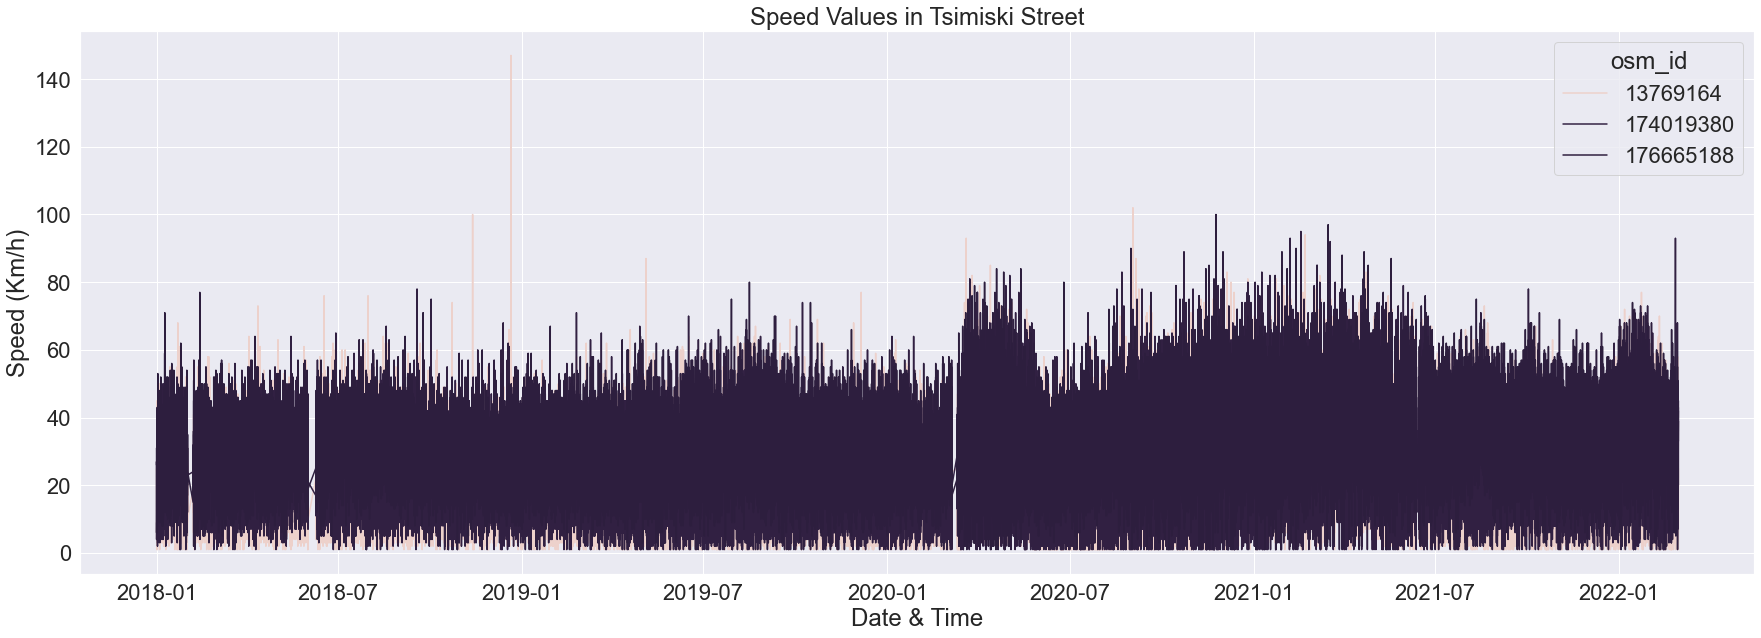

In [4]:
sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
sns.lineplot(x=o_df['date_time'], y=o_df['speed_kmph'], hue=o_df['osm_id'])
plt.ylabel('Speed (Km/h)')
plt.xlabel('Date & Time')
plt.title('Speed Values in Tsimiski Street')

In [5]:
# filter the data for processing 
df = o_df.loc[o_df['year'] == 2019] 
df = df.loc[df['osm_id'] == 176665188] # Change to df = df.loc[df['osm_id'] == 176665188] for multiple year analysis

#greater than the start date and smaller than the end date
mask = (df['date_time'] > '2019-01-01 00:00:00') & (df['date_time'] <= '2019-05-31 23:45:00') # selection format 2018-01-01 10:15:00
df = df.loc[mask]
df

,osm_id,date_time,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
285449,176665188,2019-01-01 00:15:00,1,30,00:15,0,15,3,0,1,primary,542.0,yes,2019
285450,176665188,2019-01-01 00:30:00,1,20,00:30,0,30,3,0,1,primary,542.0,yes,2019
285451,176665188,2019-01-01 00:45:00,1,13,00:45,0,45,3,0,1,primary,542.0,yes,2019
285452,176665188,2019-01-01 01:00:00,1,9,01:00,1,0,3,0,1,primary,542.0,yes,2019
285453,176665188,2019-01-01 01:15:00,1,7,01:15,1,15,3,0,1,primary,542.0,yes,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299825,176665188,2019-05-31 22:45:00,1,11,22:45,22,45,6,0,5,primary,542.0,yes,2019
299826,176665188,2019-05-31 23:00:00,1,12,23:00,23,0,6,0,5,primary,542.0,yes,2019
299827,176665188,2019-05-31 23:15:00,1,10,23:15,23,15,6,0,5,primary,542.0,yes,2019
299828,176665188,2019-05-31 23:30:00,1,14,23:30,23,30,6,0,5,primary,542.0,yes,2019


15 minutes = 4 step/hour
24 * 4 * 31 =  2976/id

Available:
8663/8928

In [6]:
# loop through id to create temp. df
osm = df['osm_id'].unique()

segments = {}
for i in range(len(osm)):
    segments['segment{}'.format(i+1)]=df[df['osm_id']==osm[i]]

ndf = pd.DataFrame()
# resample for each id
for segment in segments:
    dfs = segments[segment]
    dfs = dfs.set_index('date_time')
    dfs = dfs.resample('15T').interpolate()
    dfs = dfs.bfill()
# convert the type for some of the column
    dfs = dfs.astype({"osm_id":'int', "hours":'int', "mins":'int', "stores":'int', "n_day":'int', "n_month":'int', "year":'int'})

# append all temp. into one df
    ndf = ndf.append(dfs)
    df = ndf

In [7]:
df

,osm_id,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
date_time,,,,,,,,,,,,,
2019-01-01 00:15:00,176665188,1.0,30.0,00:15,0,15,3,0,1,primary,542.0,yes,2019
2019-01-01 00:30:00,176665188,1.0,20.0,00:30,0,30,3,0,1,primary,542.0,yes,2019
2019-01-01 00:45:00,176665188,1.0,13.0,00:45,0,45,3,0,1,primary,542.0,yes,2019
2019-01-01 01:00:00,176665188,1.0,9.0,01:00,1,0,3,0,1,primary,542.0,yes,2019
2019-01-01 01:15:00,176665188,1.0,7.0,01:15,1,15,3,0,1,primary,542.0,yes,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 22:45:00,176665188,1.0,11.0,22:45,22,45,6,0,5,primary,542.0,yes,2019
2019-05-31 23:00:00,176665188,1.0,12.0,23:00,23,0,6,0,5,primary,542.0,yes,2019
2019-05-31 23:15:00,176665188,1.0,10.0,23:15,23,15,6,0,5,primary,542.0,yes,2019


# COMPARISON SECTION

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = df.reset_index()
train_mask = (df['date_time'] > '2019-01-01 00:00:00') & (df['date_time'] <= '2019-02-14 23:45:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[train_mask]

y = wdf.speed_kmph
data_features = ['hours', 'mins', 'n_day', 'stores']
X = wdf[data_features]

# Train-test split
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

scaler = StandardScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X), index=train_X.index, columns=train_X.columns)
val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

# Comparing the models 
models = {
    "LR": LinearRegression(normalize=True), # normalize=True
    "KNN": KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='brute', p=1), # n_neighbors=5, weights='uniform', algorithm='brute', p=1
    "NN": MLPRegressor(max_iter=500, random_state=0, solver='lbfgs'), # max_iter=500, random_state=0, solver='lbfgs'
    "SVR-L": LinearSVR(C=1, epsilon=5), # C=1, epsilon=5
    "SVR-RBF": SVR(C=500, epsilon=5), # C=500, epsilon=5
    "DT": DecisionTreeRegressor(max_depth=6), # max_depth=6
    "RF": RandomForestRegressor(max_depth=6, max_features="log2", random_state=0), # max_depth=6, max_features="log2", random_state=0
    "GB": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3) # n_estimators=100, learning_rate=0.1, max_depth=3
}

for name, model in models.items():
    model.fit(train_X, train_y)
    print(name + " trained.")
    print(name + " R^2 Score: {:.5f}".format(model.score(val_X, val_y)))
    print(name + " R^2 Score: {:.5f}".format(model.score(train_X, train_y)))
  

LR trained.
LR R^2 Score: 0.26848
LR R^2 Score: 0.27232
KNN trained.
KNN R^2 Score: 0.57658
KNN R^2 Score: 0.71083
NN trained.
NN R^2 Score: 0.65050
NN R^2 Score: 0.68567
SVR-L trained.
SVR-L R^2 Score: 0.27013
SVR-L R^2 Score: 0.27137
SVR-RBF trained.
SVR-RBF R^2 Score: 0.62745
SVR-RBF R^2 Score: 0.63652
DT trained.
DT R^2 Score: 0.63371
DT R^2 Score: 0.65783
RF trained.
RF R^2 Score: 0.63899
RF R^2 Score: 0.65800
GB trained.
GB R^2 Score: 0.63807
GB R^2 Score: 0.64863


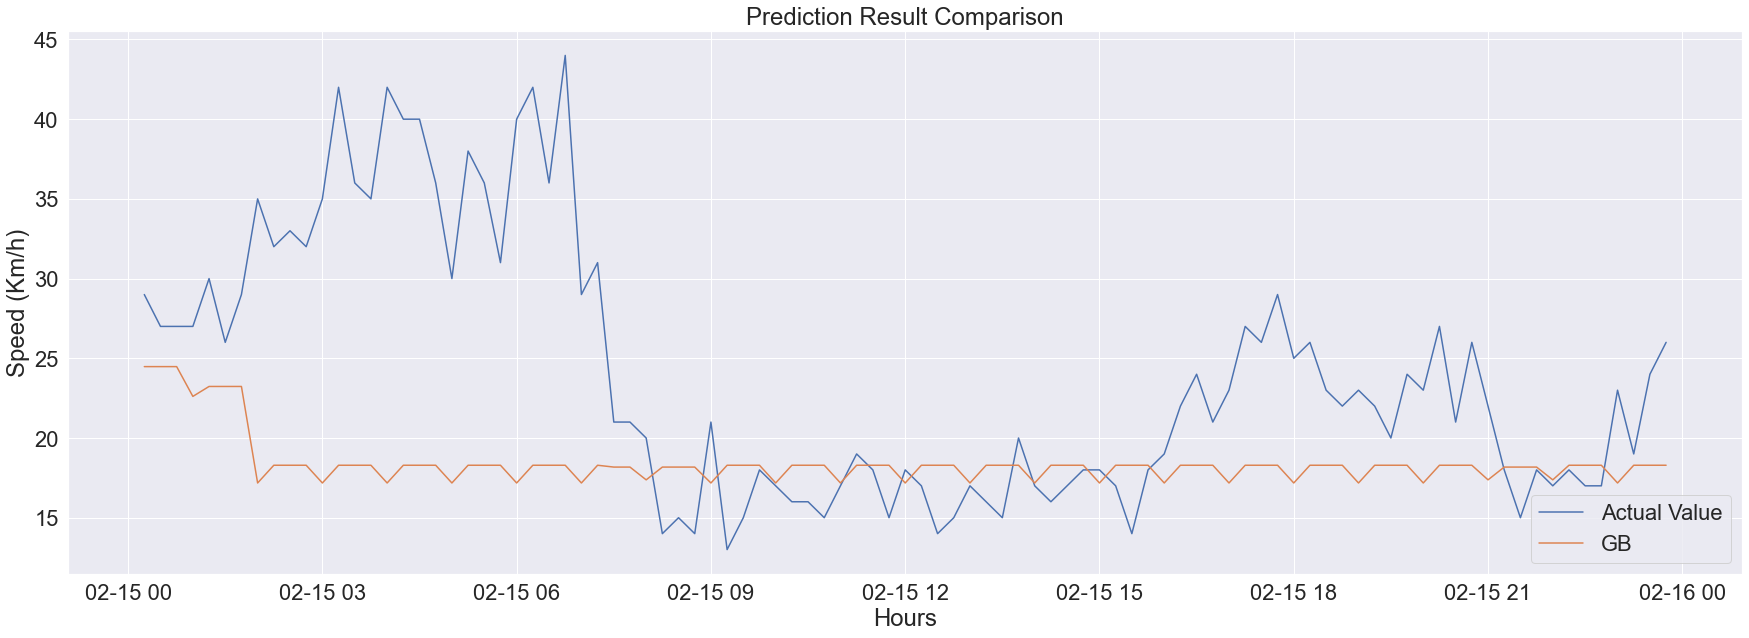

In [9]:
# For testing prediction through iteration over time 
test_mask = (df['date_time'] > '2019-02-15 00:00:00') & (df['date_time'] <= '2019-02-15 23:45:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[test_mask]
wdf = wdf.set_index('date_time')

# val_y = wdf.speed_kmph

# data_features = ['hours', 'mins', 'n_day', 'stores']
# val_X = wdf[data_features]

# val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

result = pd.DataFrame()

result['Model'] = ''
result['MAE'] = ''
result['RMSE'] = ''

result = result.astype({"MAE":'int', "RMSE":'int'})

wdf["prediction"] = wdf[['hours', 'mins', 'n_day', 'stores']].apply(
    lambda s: model.predict(s.values[None])[0], axis=1
)

# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=wdf.index, y=wdf['speed_kmph'], label='Actual Value')
ax = sns.lineplot(x=wdf.index, y=wdf['prediction'], label=name) # , hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Prediction Result Comparison")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")
plt.legend(loc='lower right')


# for row in range(len(wdf)):
#     ldf = wdf.iloc[row,:]
#     val_y = ldf.speed_kmph

#     data_features = ['hours', 'mins', 'n_day', 'stores']
#     val_X = ldf[data_features]

#     val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

#     for name, model in models.items():
#         val_predict = model.predict(val_X)
        
#         result = result.append({'Model': name, 'MAE' : mean_absolute_error(val_y, val_predict), 'RMSE': np.sqrt(mean_squared_error(val_y, val_predict))}, ignore_index=True)

In [10]:
# Scenario 1 test data (One Random Time on Random Days, Random Road)
test_mask = (df['date_time'] > '2019-02-15 00:00:00') & (df['date_time'] <= '2019-02-28 23:45:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[test_mask]
wdf = wdf.set_index('date_time')

result = pd.DataFrame()

result['Model'] = ''
result['MAE'] = ''
result['RMSE'] = ''

result = result.astype({"MAE":'int', "RMSE":'int'})

for i in range(35):
    ldf = wdf.sample()

    val_y = ldf.speed_kmph

    data_features = ['hours', 'mins', 'n_day', 'stores']
    val_X = ldf[data_features]

    val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

    for name, model in models.items():
        val_predict = model.predict(val_X)
        
        result = result.append({'Model': name, 'MAE' : mean_absolute_error(val_y, val_predict), 'RMSE': np.sqrt(mean_squared_error(val_y, val_predict))}, ignore_index=True)

In [11]:
result.groupby('Model')['MAE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,35.00,4.93,3.54,0.43,1.81,4.50,7.12,13.88
GB,35.00,5.03,3.94,0.26,1.68,4.96,6.68,14.68
KNN,35.00,4.61,4.05,0.00,1.20,3.80,6.70,15.00
LR,35.00,6.00,5.33,0.11,1.65,4.16,8.81,21.33
NN,35.00,4.74,4.35,0.07,1.40,3.99,7.13,15.68
RF,35.00,4.78,3.80,0.00,1.90,3.83,7.15,14.40
SVR-L,35.00,5.88,5.30,0.04,1.72,3.90,8.54,21.48
SVR-RBF,35.00,4.86,3.95,0.48,1.46,3.50,7.89,14.85


In [12]:
result.groupby('Model')['RMSE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,35.00,4.93,3.54,0.43,1.81,4.50,7.12,13.88
GB,35.00,5.03,3.94,0.26,1.68,4.96,6.68,14.68
KNN,35.00,4.61,4.05,0.00,1.20,3.80,6.70,15.00
LR,35.00,6.00,5.33,0.11,1.65,4.16,8.81,21.33
NN,35.00,4.74,4.35,0.07,1.40,3.99,7.13,15.68
RF,35.00,4.78,3.80,0.00,1.90,3.83,7.15,14.40
SVR-L,35.00,5.88,5.30,0.04,1.72,3.90,8.54,21.48
SVR-RBF,35.00,4.86,3.95,0.48,1.46,3.50,7.89,14.85


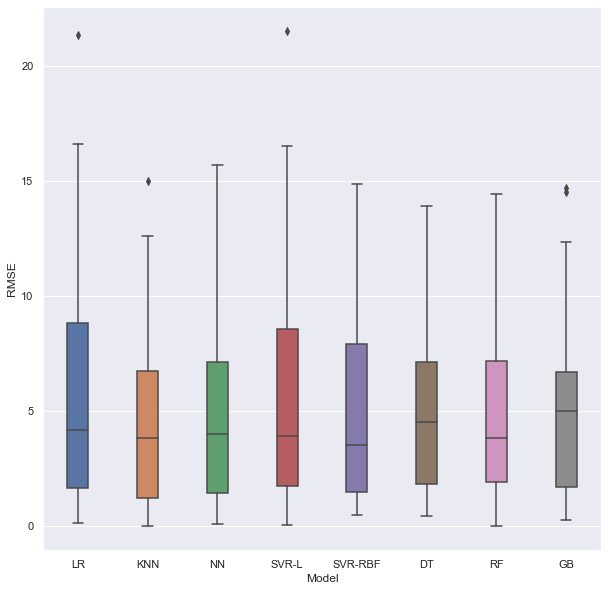

In [13]:
sns.set(rc={'figure.figsize':(10,10)}, font_scale=1)
sns.boxplot(y=result['RMSE'], x=result['Model'], width=0.3)
plt.show()

Test 1


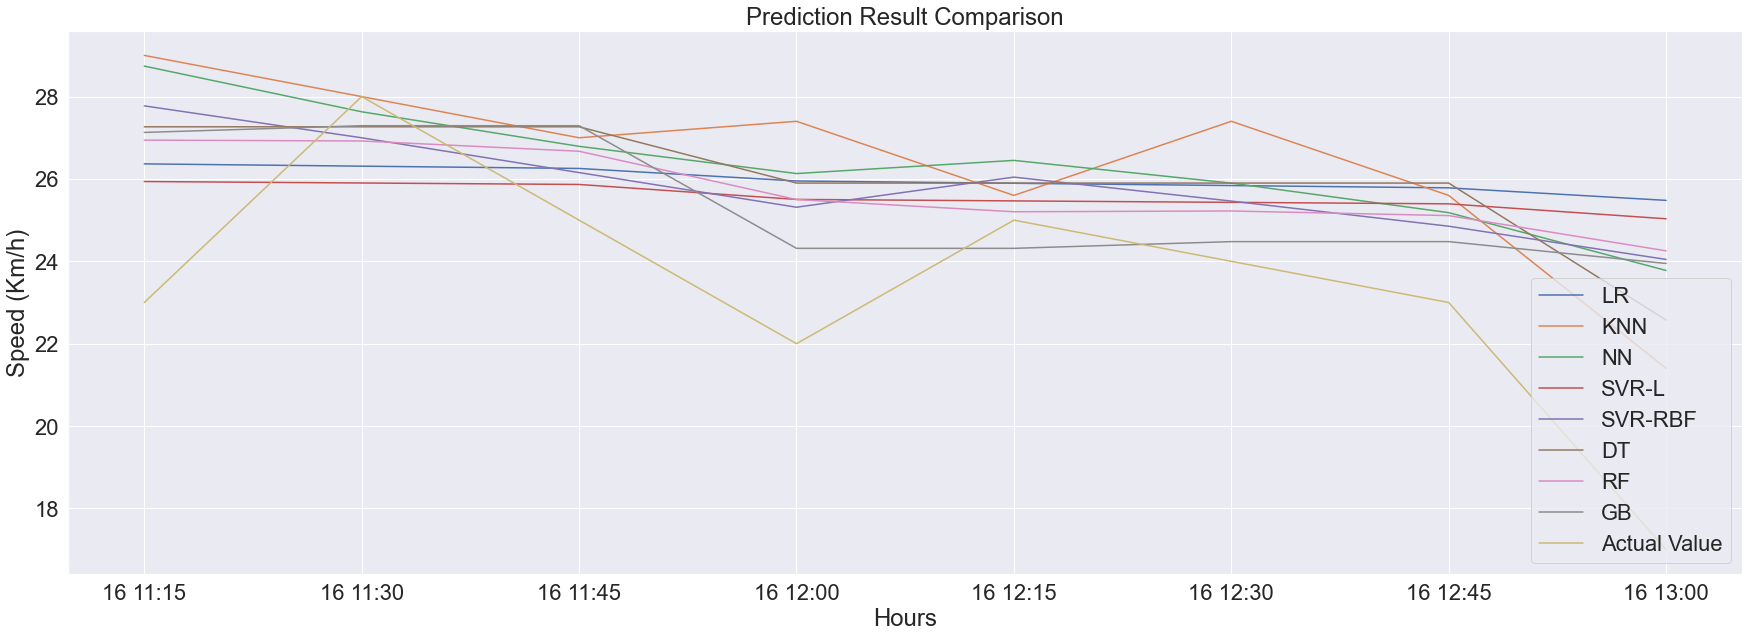

In [14]:
# Scenario 2 test data (Eight Consecutive Times on Random Days, Random Road )
test_mask1 = (df['date_time'] > '2019-02-16 11:00:00') & (df['date_time'] <= '2019-02-16 13:00:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[test_mask1]
wdf = wdf.set_index('date_time')

val_y = wdf.speed_kmph

data_features = ['hours', 'mins', 'n_day', 'stores']
val_X = wdf[data_features]

val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

print("Test 1")

result = pd.DataFrame()

result['Model'] = ''
result['MAE'] = ''
result['RMSE'] = ''
result['R2'] = ''

result = result.astype({"MAE":'int', "RMSE":'int', "R2":'int'})

for name, model in models.items():
    val_predict = model.predict(val_X)
        
    result = result.append({'Model': name, 'MAE' : mean_absolute_error(val_y, val_predict), 'RMSE': np.sqrt(mean_squared_error(val_y, val_predict)), 'R2':r2_score(val_y, val_predict)}, ignore_index=True)

    # Set your custom color palette
    customPalette = sns.set_palette(sns.color_palette("hls", 8))

    ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
    ax = sns.lineplot(x=val_X.index, y=val_predict, label=name) # , hue=val_X['osm_id'], palette=customPalette

ax = sns.lineplot(x=val_X.index, y=val_y, label='Actual Value', dashes=True) # , hue=train_X['osm_id']

# Customize the axes and title
ax.set_title("Prediction Result Comparison")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")
plt.legend(loc='lower right')

In [15]:
result.groupby('Model')['MAE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,2.80,nan,2.80,2.80,2.80,2.80,2.80
GB,1.00,2.38,nan,2.38,2.38,2.38,2.38,2.38
KNN,1.00,3.05,nan,3.05,3.05,3.05,3.05,3.05
LR,1.00,3.03,nan,3.03,3.03,3.03,3.03,3.03
NN,1.00,3.04,nan,3.04,3.04,3.04,3.04,3.04
RF,1.00,2.62,nan,2.62,2.62,2.62,2.62,2.62
SVR-L,1.00,2.72,nan,2.72,2.72,2.72,2.72,2.72
SVR-RBF,1.00,2.71,nan,2.71,2.71,2.71,2.71,2.71


In [16]:
result.groupby('Model')['RMSE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,3.22,nan,3.22,3.22,3.22,3.22,3.22
GB,1.00,3.15,nan,3.15,3.15,3.15,3.15,3.15
KNN,1.00,3.66,nan,3.66,3.66,3.66,3.66,3.66
LR,1.00,3.80,nan,3.80,3.80,3.80,3.80,3.80
NN,1.00,3.70,nan,3.70,3.70,3.70,3.70,3.70
RF,1.00,3.36,nan,3.36,3.36,3.36,3.36,3.36
SVR-L,1.00,3.51,nan,3.51,3.51,3.51,3.51,3.51
SVR-RBF,1.00,3.40,nan,3.40,3.40,3.40,3.40,3.40


In [17]:
result.groupby('Model')['R2'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,-0.19,nan,-0.19,-0.19,-0.19,-0.19,-0.19
GB,1.00,-0.14,nan,-0.14,-0.14,-0.14,-0.14,-0.14
KNN,1.00,-0.53,nan,-0.53,-0.53,-0.53,-0.53,-0.53
LR,1.00,-0.65,nan,-0.65,-0.65,-0.65,-0.65,-0.65
NN,1.00,-0.57,nan,-0.57,-0.57,-0.57,-0.57,-0.57
RF,1.00,-0.29,nan,-0.29,-0.29,-0.29,-0.29,-0.29
SVR-L,1.00,-0.41,nan,-0.41,-0.41,-0.41,-0.41,-0.41
SVR-RBF,1.00,-0.32,nan,-0.32,-0.32,-0.32,-0.32,-0.32


Test 2


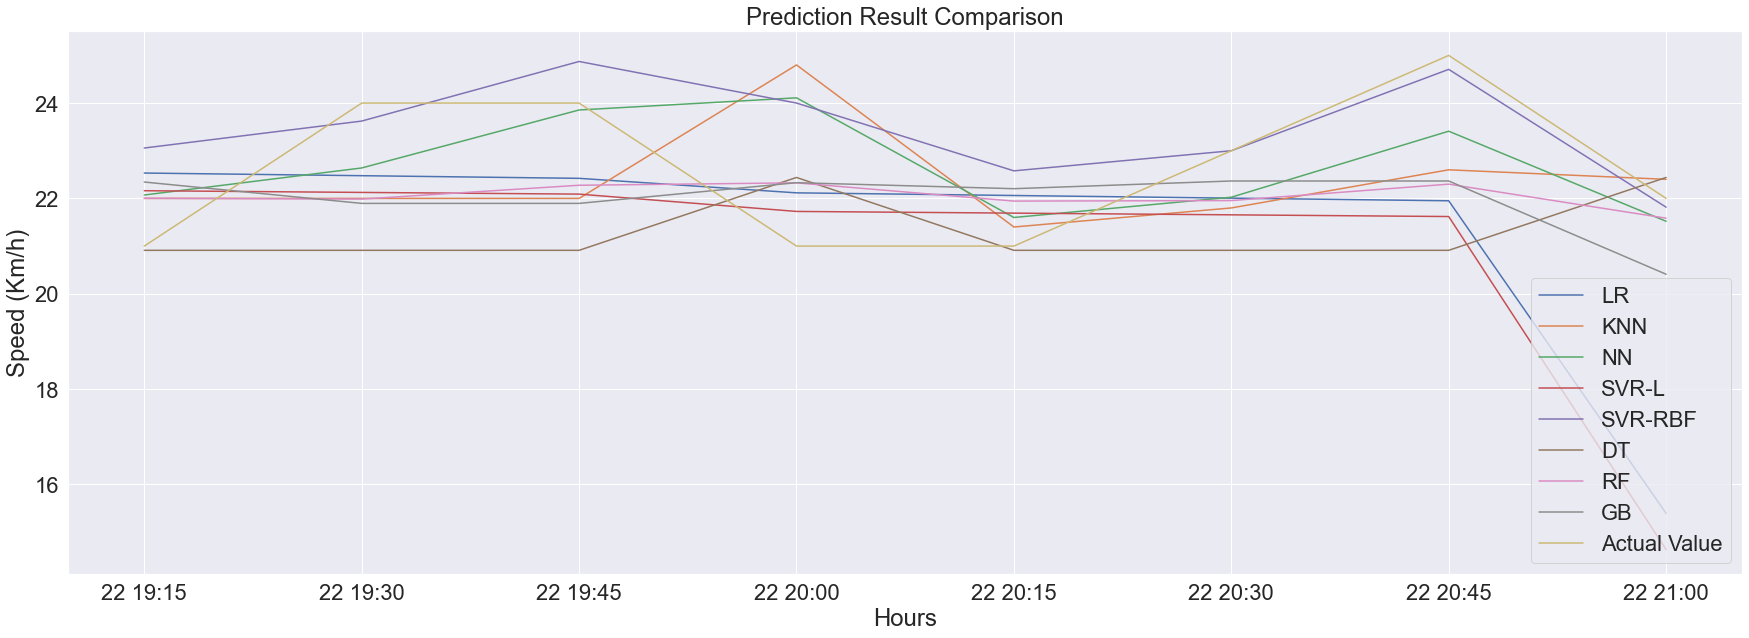

In [18]:
# Another Test
test_mask2 = (df['date_time'] > '2019-02-22 19:00:00') & (df['date_time'] <= '2019-02-22 21:00:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[test_mask2]
wdf = wdf.set_index('date_time')

val_y = wdf.speed_kmph

data_features = ['hours', 'mins', 'n_day', 'stores']
val_X = wdf[data_features]

val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

print("Test 2")

result = pd.DataFrame()

result['Model'] = ''
result['MAE'] = ''
result['RMSE'] = ''
result['R2'] = ''

result = result.astype({"MAE":'int', "RMSE":'int', "R2":'int'})

for name, model in models.items():
    val_predict = model.predict(val_X)
        
    result = result.append({'Model': name, 'MAE' : mean_absolute_error(val_y, val_predict), 'RMSE': np.sqrt(mean_squared_error(val_y, val_predict)), 'R2':r2_score(val_y, val_predict)}, ignore_index=True)

    # Set your custom color palette
    customPalette = sns.set_palette(sns.color_palette("hls", 8))

    ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
    ax = sns.lineplot(x=val_X.index, y=val_predict, label=name) # , hue=val_X['osm_id'], palette=customPalette

ax = sns.lineplot(x=val_X.index, y=val_y, label='Actual Value') # , hue=train_X['osm_id']

# Customize the axes and title
ax.set_title("Prediction Result Comparison")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")
plt.legend(loc='lower right')

In [19]:
result.groupby('Model')['MAE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,1.80,nan,1.80,1.80,1.80,1.80,1.80
GB,1.00,1.62,nan,1.62,1.62,1.62,1.62,1.62
KNN,1.00,1.65,nan,1.65,1.65,1.65,1.65,1.65
LR,1.00,2.18,nan,2.18,2.18,2.18,2.18,2.18
NN,1.00,1.17,nan,1.17,1.17,1.17,1.17,1.17
RF,1.00,1.40,nan,1.40,1.40,1.40,1.40,1.40
SVR-L,1.00,2.31,nan,2.31,2.31,2.31,2.31,2.31
SVR-RBF,1.00,1.05,nan,1.05,1.05,1.05,1.05,1.05


In [20]:
result.groupby('Model')['RMSE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,2.30,nan,2.30,2.30,2.30,2.30,2.30
GB,1.00,1.72,nan,1.72,1.72,1.72,1.72,1.72
KNN,1.00,1.97,nan,1.97,1.97,1.97,1.97,1.97
LR,1.00,2.82,nan,2.82,2.82,2.82,2.82,2.82
NN,1.00,1.45,nan,1.45,1.45,1.45,1.45,1.45
RF,1.00,1.55,nan,1.55,1.55,1.55,1.55,1.55
SVR-L,1.00,3.10,nan,3.10,3.10,3.10,3.10,3.10
SVR-RBF,1.00,1.45,nan,1.45,1.45,1.45,1.45,1.45


In [21]:
result.groupby('Model')['R2'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,-1.37,nan,-1.37,-1.37,-1.37,-1.37,-1.37
GB,1.00,-0.33,nan,-0.33,-0.33,-0.33,-0.33,-0.33
KNN,1.00,-0.73,nan,-0.73,-0.73,-0.73,-0.73,-0.73
LR,1.00,-2.55,nan,-2.55,-2.55,-2.55,-2.55,-2.55
NN,1.00,0.06,nan,0.06,0.06,0.06,0.06,0.06
RF,1.00,-0.08,nan,-0.08,-0.08,-0.08,-0.08,-0.08
SVR-L,1.00,-3.31,nan,-3.31,-3.31,-3.31,-3.31,-3.31
SVR-RBF,1.00,0.06,nan,0.06,0.06,0.06,0.06,0.06


Test 1


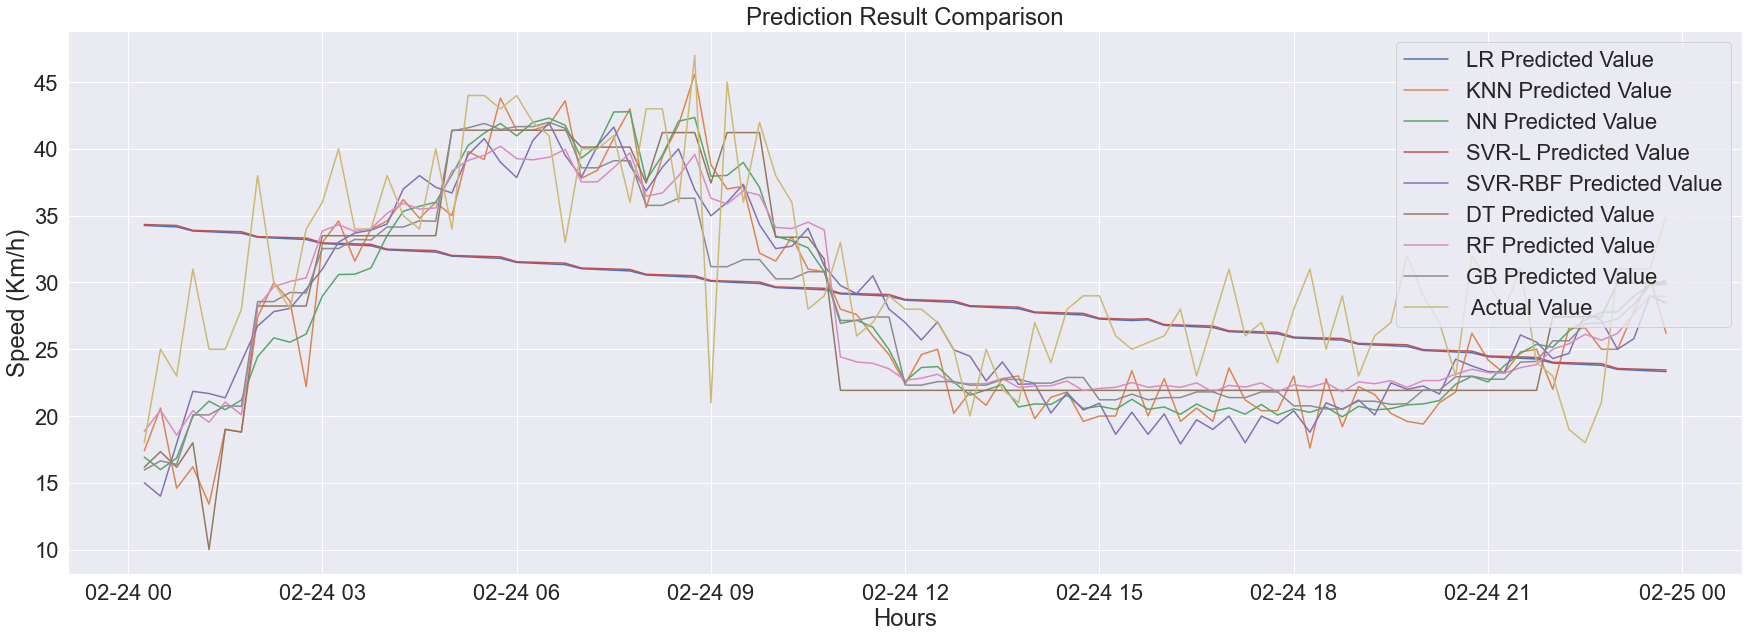

In [23]:
# Scenario 3 test data (Random Days, Random Roads)
test_mask1 = (df['date_time'] > '2019-02-24 00:00:00') & (df['date_time'] <= '2019-02-24 23:45:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[test_mask1]
wdf = wdf.set_index('date_time')

val_y = wdf.speed_kmph

data_features = ['hours', 'mins', 'n_day', 'stores']
val_X = wdf[data_features]

val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

print("Test 1")

result = pd.DataFrame()

result['Model'] = ''
result['MAE'] = ''
result['RMSE'] = ''
result['R2'] = ''

result = result.astype({"MAE":'int', "RMSE":'int', "R2":'int'})

for name, model in models.items():
    val_predict = model.predict(val_X)
        
    result = result.append({'Model': name, 'MAE' : mean_absolute_error(val_y, val_predict), 'RMSE': np.sqrt(mean_squared_error(val_y, val_predict)), 'R2':r2_score(val_y, val_predict)}, ignore_index=True)

    # Set your custom color palette
    # plt.figure()
    ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
    ax = sns.lineplot(x=val_X.index, y=val_predict, label=name+' Predicted Value') # , hue=val_X['osm_id'], palette=customPalette

ax = sns.lineplot(x=val_X.index, y=val_y, label=' Actual Value') # , hue=train_X['osm_id']
    
# Customize the axes and title
ax.set_title("Prediction Result Comparison")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")
plt.legend(loc='upper right')

In [24]:
result.groupby('Model')['MAE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,4.75,nan,4.75,4.75,4.75,4.75,4.75
GB,1.00,4.67,nan,4.67,4.67,4.67,4.67,4.67
KNN,1.00,4.91,nan,4.91,4.91,4.91,4.91,4.91
LR,1.00,5.14,nan,5.14,5.14,5.14,5.14,5.14
NN,1.00,4.92,nan,4.92,4.92,4.92,4.92,4.92
RF,1.00,4.38,nan,4.38,4.38,4.38,4.38,4.38
SVR-L,1.00,5.13,nan,5.13,5.13,5.13,5.13,5.13
SVR-RBF,1.00,4.84,nan,4.84,4.84,4.84,4.84,4.84


In [25]:
result.groupby('Model')['RMSE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,5.81,nan,5.81,5.81,5.81,5.81,5.81
GB,1.00,5.61,nan,5.61,5.61,5.61,5.61,5.61
KNN,1.00,6.12,nan,6.12,6.12,6.12,6.12,6.12
LR,1.00,6.58,nan,6.58,6.58,6.58,6.58,6.58
NN,1.00,5.85,nan,5.85,5.85,5.85,5.85,5.85
RF,1.00,5.17,nan,5.17,5.17,5.17,5.17,5.17
SVR-L,1.00,6.55,nan,6.55,6.55,6.55,6.55,6.55
SVR-RBF,1.00,5.74,nan,5.74,5.74,5.74,5.74,5.74


In [26]:
result.groupby('Model')['R2'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,0.30,nan,0.30,0.30,0.30,0.30,0.30
GB,1.00,0.35,nan,0.35,0.35,0.35,0.35,0.35
KNN,1.00,0.22,nan,0.22,0.22,0.22,0.22,0.22
LR,1.00,0.10,nan,0.10,0.10,0.10,0.10,0.10
NN,1.00,0.29,nan,0.29,0.29,0.29,0.29,0.29
RF,1.00,0.44,nan,0.44,0.44,0.44,0.44,0.44
SVR-L,1.00,0.11,nan,0.11,0.11,0.11,0.11,0.11
SVR-RBF,1.00,0.32,nan,0.32,0.32,0.32,0.32,0.32


Test 2


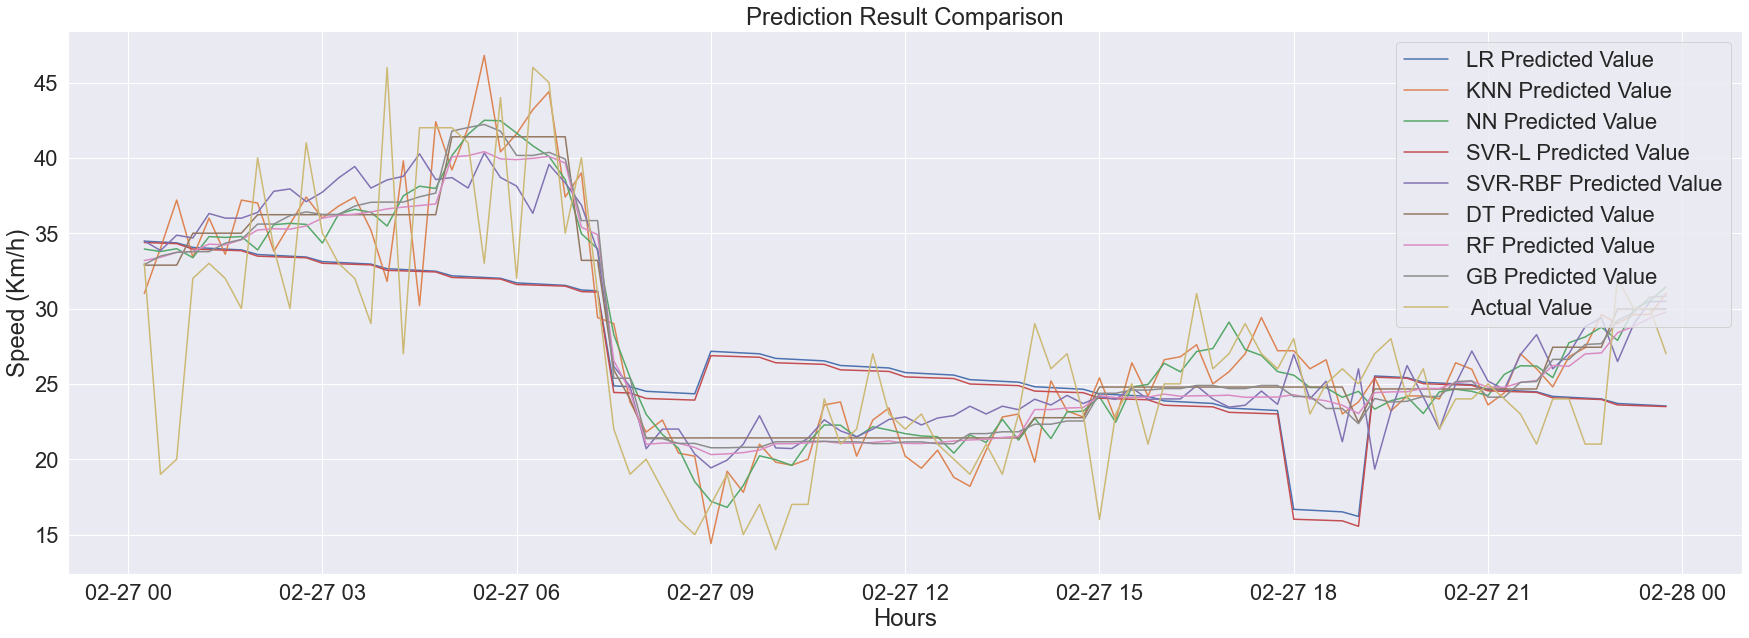

In [27]:
# Another Test
test_mask2 = (df['date_time'] > '2019-02-27 00:00:00') & (df['date_time'] <= '2019-02-27 23:45:00') # selection format 2018-01-01 10:15:00
wdf = df.loc[test_mask2]
wdf = wdf.set_index('date_time')

val_y = wdf.speed_kmph

data_features = ['hours', 'mins', 'n_day', 'stores']
val_X = wdf[data_features]

val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

print("Test 2")

result = pd.DataFrame()

result['Model'] = ''
result['MAE'] = ''
result['RMSE'] = ''
result['R2'] = ''

result = result.astype({"MAE":'int', "RMSE":'int', "R2":'int'})

for name, model in models.items():
    val_predict = model.predict(val_X)
        
    result = result.append({'Model': name, 'MAE' : mean_absolute_error(val_y, val_predict), 'RMSE': np.sqrt(mean_squared_error(val_y, val_predict)), 'R2':r2_score(val_y, val_predict)}, ignore_index=True)

    # Set your custom color palette
    # plt.figure()
    ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
    ax = sns.lineplot(x=val_X.index, y=val_predict, label=name+' Predicted Value') # , hue=val_X['osm_id'], palette=customPalette


ax = sns.lineplot(x=val_X.index, y=val_y, label=' Actual Value') # , hue=train_X['osm_id']

# Customize the axes and title
ax.set_title("Prediction Result Comparison")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")
plt.legend(loc='upper right')

In [28]:
result.groupby('Model')['MAE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,3.45,nan,3.45,3.45,3.45,3.45,3.45
GB,1.00,3.47,nan,3.47,3.47,3.47,3.47,3.47
KNN,1.00,3.47,nan,3.47,3.47,3.47,3.47,3.47
LR,1.00,5.04,nan,5.04,5.04,5.04,5.04,5.04
NN,1.00,3.35,nan,3.35,3.35,3.35,3.35,3.35
RF,1.00,3.43,nan,3.43,3.43,3.43,3.43,3.43
SVR-L,1.00,5.02,nan,5.02,5.02,5.02,5.02,5.02
SVR-RBF,1.00,3.86,nan,3.86,3.86,3.86,3.86,3.86


In [29]:
result.groupby('Model')['RMSE'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,4.46,nan,4.46,4.46,4.46,4.46,4.46
GB,1.00,4.48,nan,4.48,4.48,4.48,4.48,4.48
KNN,1.00,4.95,nan,4.95,4.95,4.95,4.95,4.95
LR,1.00,6.41,nan,6.41,6.41,6.41,6.41,6.41
NN,1.00,4.47,nan,4.47,4.47,4.47,4.47,4.47
RF,1.00,4.38,nan,4.38,4.38,4.38,4.38,4.38
SVR-L,1.00,6.40,nan,6.40,6.40,6.40,6.40,6.40
SVR-RBF,1.00,4.89,nan,4.89,4.89,4.89,4.89,4.89


In [30]:
result.groupby('Model')['R2'].describe().applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
DT,1.00,0.65,nan,0.65,0.65,0.65,0.65,0.65
GB,1.00,0.65,nan,0.65,0.65,0.65,0.65,0.65
KNN,1.00,0.57,nan,0.57,0.57,0.57,0.57,0.57
LR,1.00,0.29,nan,0.29,0.29,0.29,0.29,0.29
NN,1.00,0.65,nan,0.65,0.65,0.65,0.65,0.65
RF,1.00,0.67,nan,0.67,0.67,0.67,0.67,0.67
SVR-L,1.00,0.29,nan,0.29,0.29,0.29,0.29,0.29
SVR-RBF,1.00,0.59,nan,0.59,0.59,0.59,0.59,0.59


# END OF COMPARISON SECTION

In [ ]:
# Use only when multiple road segments are selected
df = df.reset_index()
df

In [ ]:
sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
sns.lineplot(x=df.index, y=df['speed_kmph'], hue=df['osm_id']) # x=df.index, for single road segment x=df['date_time'], for multiple road segments
plt.ylabel('Speed (Km/h)')
plt.xlabel('Date & Time')
plt.title('Selected Data')

In [ ]:
"""
CODE DUMP:

df['is_weekend'] = ''
df['is_weekday'] = ''

for i in range(len(df)):
    check = df.iat[i,6]
    if df.iat[i,6] != 1 and df.iat[i,6] != 7:
        df.iat[i,13] = 0
        df.iat[i,14] = 1
    else:
        df.iat[i,13] = 1
        df.iat[i,14] = 0

df = df.astype({"is_weekend":'int', "is_weekday":'int'})
"""

# Split df into X and y
# selecting the prediction target (label)
y = df.speed_kmph
    
# convert all the features with label encoder
df['highway_n'] = LabelEncoder().fit_transform(df['highway'])
df['bus_stop_n'] = LabelEncoder().fit_transform(df['bus_stop'])

"""
CODE DUMP:
Feature encoder
Because the data have been prepared accordingly for day, month and stores
df['n_time_n'] = LabelEncoder().fit_transform(df['n_time'])
df['n_day_n'] = LabelEncoder().fit_transform(df['n_day'])
df['n_month_n'] = LabelEncoder().fit_transform(df['n_month'])
df['stores_n'] = LabelEncoder().fit_transform(df['stores'])

For selecting features:
- One month data (one segments): data_features = ['hours', 'mins', 'n_day', 'stores']
- One month data (mult. segments): data_features = ['osm_id', 'hours', 'mins', 'n_day', 'stores','road_lt_m', 'bus_stop']
- Mult. month data (one segments): data_features = ['hours', 'mins', 'n_day', 'n_month', 'stores']
- Mult. month data (mult. segments): data_features = ['osm_id', 'hours', 'mins', 'n_day', 'n_month', 'stores', 'road_lt_m', 'bus_stop']
"""

# selecting the 'features', depending on the data
data_features = ['hours', 'mins', 'n_day', 'stores']
X = df[data_features]

X.head()

In [ ]:
# Inspect the data
print('DATA INSPECTION RESULTS:')
print('osm id values:', df['osm_id'].unique())
print('day values:', df['n_day'].unique())
print('month values:', df['n_month'].unique())
print('stores values:', df['stores'].unique())
print('link_dir values:', df['link_dir'].unique())
print('highway values:', df['highway'].unique())
print('year values:', df['year'].unique())

In [ ]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

# Visualizing Correlation
sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
sns.heatmap(df.corr(), annot=True, vmin=-1.0, cmap='mako')
plt.title('Data Correlation')
plt.show()

In [ ]:
# Train-test split
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=train_X['hours'], y=train_y, hue=train_X['osm_id']) # , label='Training Data', hue=train_X['osm_id']
ax = sns.lineplot(x=val_X['hours'], y=val_y, hue=val_X['osm_id']) # , label='Test Data', hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed in Km/h")

In [ ]:
# Scale X
print('Variance before scaler:', train_X.var(), sep='\n')
print('\n')
scaler = StandardScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X), index=train_X.index, columns=train_X.columns)
val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

print('Variance after scaler:', train_X.var(), sep='\n')
print('\n')

print(train_X)
print(val_X)
print(train_y)
print(val_y)

# Model Links
- LR    : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- KNN   : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor#sklearn.neighbors.KNeighborsRegressor
- MLP   : https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- SVR   : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html or https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html
- DT    : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- RF    : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- GB    : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

Additional about R2 negative
https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean#:~:text=R2%20can%20be%20negative,fits%20your%20data%20very%20badly

In [ ]:
# Comparing the models 
models = {
    "                     Linear Regression": LinearRegression(normalize=True), # normalize=True
    "                   K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='brute', p=1), # n_neighbors=5, weights='uniform', algorithm='brute', p=1
    "                        Neural Network": MLPRegressor(max_iter=500, random_state=0, solver='lbfgs'), # max_iter=500, random_state=0, solver='lbfgs'
    "Support Vector Machine (Linear Kernel)": LinearSVR(C=1, epsilon=5), # C=1, epsilon=5
    "   Support Vector Machine (RBF Kernel)": SVR(C=500, epsilon=5), # C=500, epsilon=5
    "                         Decision Tree": DecisionTreeRegressor(max_depth=6), # max_depth=6
    "                         Random Forest": RandomForestRegressor(max_depth=6, max_features="log2", random_state=0), # max_depth=6, max_features="log2", random_state=0
    "                     Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3) # n_estimators=100, learning_rate=0.1, max_depth=3
}

for name, model in models.items():
    model.fit(train_X, train_y)
    print(name + " trained.")

In [ ]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(val_X, val_y)))
    print(name + " R^2 Score: {:.5f}".format(model.score(train_X, train_y)))

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

for name, model in models.items():
    val_predict = model.predict(val_X)
    print(name + " R^2 Score: {:.5f}".format(r2_score(val_y, val_predict)))
    print(name + " RMSE: {:.5f}".format(np.sqrt(mean_squared_error(val_y, val_predict))))
    print(name + " MAE: {:.5f}".format(mean_absolute_error(val_y, val_predict)))

In [ ]:
# Specifying and creating the MODEL
# Change the model accordingly!
data_model = GradientBoostingRegressor()
data_model.fit(train_X, train_y)

In [ ]:
# PREDICTING and VALIDATING the values
val_predictions = data_model.predict(val_X)

print('R^2 Score =', r2_score(val_y, val_predictions))
print('Mean Absolute Error =', mean_absolute_error(val_y, val_predictions))
print('Root Mean Squared Error =', np.sqrt(mean_squared_error(val_y, val_predictions)))

# Implementing Cross Validation techniques
from sklearn.model_selection import cross_val_score
scores = cross_val_score(data_model, train_X, train_y, cv=10)
scores

In [ ]:
plt.figure(figsize=(30,10))
n=len(val_y)
plt.plot(range(n), val_y, color = 'red', label = 'Actual Speed')
plt.plot(range(n), val_predictions, color = 'black', label = 'Prediction')
plt.legend(loc = 'best')
plt.ylabel('Speed (Km/h)')
plt.title('Actual & Predicted Value')
plt.show()

In [ ]:
# Inverse transform the X data for plot

print('Before Inverse Scaler:')
print("Training Data", train_X)
print("Test Data", val_X)

train_X = pd.DataFrame(scaler.inverse_transform(train_X), index=train_X.index, columns=train_X.columns)
val_X = pd.DataFrame(scaler.inverse_transform(val_X), index=val_X.index, columns=val_X.columns)

print("After Inverse Scaler:")
print("Training Data", train_X)
print("Test Data", val_X)

In [ ]:
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=val_X['hours'], y=val_y, label='Actual Value') # , hue=train_X['osm_id']
ax = sns.lineplot(x=val_X['hours'], y=val_predict, label='Predicted Value') # , hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")

In [ ]:
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=val_X.index, y=val_y, label='Actual Value') # , hue=train_X['osm_id']
ax = sns.lineplot(x=val_X.index, y=val_predict, label='Predicted Value') # , hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")

In [ ]:
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=val_X['hours'], y=val_y, hue=val_X['osm_id'], style=val_X['osm_id']) # , label='Actual Value', hue=train_X['osm_id']
ax = sns.lineplot(x=val_X['hours'], y=val_predict, hue=val_X['osm_id'], style=val_X['osm_id']) # , label='Predicted Value', hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")